# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b512_custom/lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.3min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.932,0.453,-0.415,1.317,-3.572,1.700,0.932,0.453,-0.415,1.317,-3.572,1.700,-0.009,-0.227,0.442,0.385,0.197,0.132,0.469,-0.297,0.369,0.089,0.602,-0.088,-0.019,0.486,0.119,0.538,-0.013,0.231,0.292,0.257,-0.023,0.042,0.008,-0.042,-0.404,-0.090,0.363,-0.291,-0.209,-0.233,0.000,0.000,-0.224,-0.252,0.230,0.230,-0.334,0.000,-0.287,0.292,-0.172,0.000,0.000,-0.283,0.239,-0.222,0.228,0.250,0.223,0.239,0.283,-0.047,-0.023,0.000,0.000,0.000,-0.298,0.000,0.000,0.000,-0.254,-0.359,-0.620,-0.768,0.348,0.404,-0.558,-0.408,-0.881,0.124,-0.408,-0.352,-0.364,-0.506,0.345,-0.494,0.682,0.222,0.358,0.252,0.332,-0.310,-0.044,-0.261,-0.383,-0.059,-1.071,0.144,-0.258,-0.315,0.199
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.516,-0.878,0.013,-0.029,0.029,-0.011,-0.516,-0.878,0.013,-0.029,0.029,-0.011,-0.009,-0.227,0.356,0.250,0.176,0.080,0.313,-0.297,0.217,0.381,0.480,-0.088,-0.019,0.359,0.078,0.465,0.008,0.230,0.269,0.248,0.033,0.164,0.106,-0.042,-0.404,-0.090,0.176,-0.291,-0.209,-0.233,0.000,0.000,0.115,0.115,-0.000,-0.082,0.121,0.000,0.115,0.141,0.119,0.000,0.000,0.120,-0.080,0.116,-0.023,-0.010,-0.001,-0.001,-0.040,0.114,0.132,0.000,0.000,0.000,0.114,0.000,0.000,0.000,-0.254,-0.359,-0.385,-0.385,0.136,0.187,-0.227,-0.408,-0.411,-0.115,-0.248,-0.352,-0.364,-0.243,0.121,-0.325,0.394,0.020,0.193,0.072,0.049,-0.455,-0.188,-0.261,-0.383,-0.059,-0.481,0.144,-0.258,-0.315,-0.108
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.732,0.641,3.214,-6.635,10.057,-4.010,-0.732,0.641,3.214,-6.635,10.057,-4.010,-0.009,-0.227,-0.113,0.087,0.748,0.719,0.120,-0.297,0.069,0.915,0.313,-0.088,-0.019,0.379,0.731,0.032,0.582,0.849,0.849,0.854,0.724,0.040,0.007,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,0.424,-0.096,-0.319,-0.453,-0.120,0.000,-0.081,-0.490,0.080,0.000,0.000,0.000,-0.522,0.423,-0.495,-0.244,0.000,-0.070,-0.573,-0.055,-0.025,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.433,-0.219,0.883,1.113,-0.006,-0.408,-0.254,0.726,0.047,-0.352,-0.364,0.221,1.094,-0.267,1.565,0.684,0.773,0.655,1.154,-0.307,-0.043,-0.261,-0.383,-0.059,-0.332,0.144,-0.258,-0.315,-0.440
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.167,-0.416,-1.639,5.490,-6.843,1.735,0.167,-0.416,-1.639,5.490,-6.843,1.735,-0.009,-0.227,0.418,0.533,0.125,0.058,0.582,-0.297,0.520,0.657,0.558,-0.088,-0.019,0.437,0.060,0.538,0.007,0.194,0.210,0.202,0.030,0.486,0.561,-0.042,-0.404,-0.090,0.494,-0.291,-0.209,-0.233,0.000,0.000,-0.001,-0.360,0.095,0.099,-0.343,0.000,-0.385,-0.303,-0.001,0.000,0.000,-0.001,0.094,-0.001,-0.026,0.023,0.098,0.078,-0.047,-0.429,-0.478,0.000,0.000,0.000,-0.395,0.000,0.000,0.000,-0.254,-0.359,-0.421,-1.069,0.133,0.180,-0.792,-0.408,-1.191,-0.539,-0.299,-0.352,-0.364,-0.292,0.113,-0.376,0.392,0.002,0.161,0.042,0.043,-1.392,-1.335,-0.261,-0.383,-0.059,-1.363,0.144,-0.258,-0.315,0.111
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.118,0.296,1.074,-1.688,4.175,-1.750,0.118,0.296,1.074,-1.688,4.175,-1.750,-0.009,-0.227,0.127,0.082,0.629,0.546,0.108,-0.297,0.067,1.027,0.457,-0.088,-0.019,0.125,0.587,0.271,0.286,0.740,0.589,0.714,0.661,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,0.005,-0.030,0.125,-0.478,0.727,-0.348,0.005,-0.030,0.125,-0.478,0.727,-0.348,-0.009,-0.227,0.293,0.203,0.291,0.233,0.286,-0.297,0.173,0.469,0.479,-0.088,-0.019,0.329,0.236,0.408,0.086,0.418,0.373,0.399,0.164,0.121,0.067,-0.042,-0.404,-0.090,0.133,-0.291,-0.209,-0.233,0.000,0.000,-0.013,-0.029,-0.008,-0.018,-0.051,0.000,-0.031,-0.085,-0.030,0.000,0.000,-0.041,-0.029,0.003,0.006,-0.062,0.025,-0.018,-0.027,-0.025,-0.004,0.000,0.000,0.000,-0.025,0.000,0.000,0.000,-0.254,-0.359,-0.381,-0.437,0.366,0.431,-0.236,-0.408,-0.480,0.035,-0.124,-0.352,-0.364,-0.215,0.379,-0.271,0.633,0.150,0.358,0.197,0.339,-0.531,-0.260,-0.261,-0.383,-0.059,-0.556,0.144,-0.258,-0.315,0.003
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.543,0.628,2.002,6.499,9.062,3.879,0.543,0.628,2.002,6.499,9.062,3.879,0.000,0.000,0.137,0.148,0.158,0.162,0.174,0.000,0.150,0.286,0.204,0.000,0.000,0.169,0.172,0.141,0.158,0.242,0.153,0.192,0.218,0.150,0.194,0.000,0.000,0.000,0.149,0.000,0.000,0.000,0.000,0.000,0.147,0.162,0.173,0.185,0.195,0.000,0.167,0.311,0.211,0.000,0.000,0.186,0.205,0.139,0.169,0.257,0.129,0.202,0.232,0.166,0.192,0.000,0.000,0.000,0.163,0.000,0.000,0.000,0.000,0.000,0.180,0.249,0.224,0.262,0.318,0.000,0.276,0.433,0.398,0.000,0.000,0.313,0.282,0.211,0.323,0.456,0.166,0.385,0.360,0.307,0.342,0.000,0.000,0.000,0.298,0.000,0.000,0.000,0.139
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.035,-2.379,-17.459,-55.031,-87.127,-32.496,-1.035,-2.379,-17.459,-55.031,-87.127,-32.496,-0.009,-0.227,-0.163,-0.280,-0.204,-0.236,-0.174,-0.297,-0.321,-0.101,0.118,-0.088,-0.019,-0.111,-0.248,0.004,-0.296,-0.150,-0.084,-0.121,-0.339,-0.338,-0.400,-0.042,-0.404,-0.090,-0.325,-0.291,-0.209,-0.233,0.000,0.000,-0.513,-0.573,-0.632,-0.630,-1.030,0.000,-0.518,-1.209,-1.225,0.000,0.000,-1.040,-0.641,-1.053,-0.654,-1.207,-0.635,-1.101,-0.908,-0.555,-0.822,0.000,0.000,0.000,-0.529,0.000,0.000,0.000,-0.254,-0.359,-1.379,-1.924,-0.696,0.087,-1.230,-0.408,-1.917,-2.144,-1.359,-0.352,-0.364,-1.130,0.012,-1.456,0.324,-2.709,-1.016,-2.501,-0.408,-2.168,-2.306,-0.26

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,-0.048,-0.460,0.430,0.914,-0.330,-1.242,2.828,-9.076,11.258,-3.884,-0.330,-1.242,2.828,-9.076,11.258,-3.884,-0.009,-0.227,0.355,0.249,0.431,0.417,0.313,-0.297,0.217,0.382,0.480,-0.088,-0.019,0.359,0.457,0.464,0.008,0.526,0.466,0.485,0.588,0.164,0.108,-0.042,-0.404,-0.090,0.176,-0.291,-0.209,-0.233,0.000,0.000,0.079,0.079,-0.283,-0.314,0.082,0.000,0.079,0.092,0.081,0.000,0.000,0.081,-0.367,0.080,-0.023,-0.374,-0.229,-0.288,-0.494,0.079,0.087,0.000,0.000,0.000,0.079,0.000,0.000,0.000,-0.254,-0.359,-0.371,-0.366,0.756,0.960,-0.211,-0.408,-0.390,-0.099,-0.236,-0.352,-0.364,-0.229,0.951,-0.313,0.394,0.632,0.617,0.587,1.399,-0.431,-0.156,-0.261,-0.383,-0.059,-0.458,0.144,-0.258,-0.315,-0.077
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,-0.135,-0.513,-0.351,-0.981,3.278,-2.844,0.798,-0.513,-0.351,-0.981,3.278,-2.844,0.798,-0.009,-0.227,0.249,0.140,0.286,0.230,0.200,-0.297,0.107,0.250,0.373,-0.088,-0.019,0.249,0.228,0.359,0.008,0.352,0.382,0.364,0.220,0.053,-0.056,-0.042,-0.404,-0.090,0.066,-0.291,-0.209,-0.233,0.000,0.000,0.128,0.129,-0.129,-0.123,0.134,0.000,0.130,0.154,0.130,0.000,0.000,0.132,-0.134,0.128,-0.023,-0.141,-0.104,-0.123,-0.147,0.131,0.168,0.000,0.000,0.000,0.130,0.000,0.000,0.000,-0.254,-0.359,-0.314,-0.330,0.325,0.378,-0.163,-0.408,-0.365,-0.049,-0.168,-0.352,-0.364,-0.173,0.316,-0.245,0.393,0.199,0.348,0.234,0.328,-0.430,-0.230,-0.261,-0.383,-0.059,-0.450,0.144,-0.258,-0.315,-0.123
6925,1373158606,-0.316,0.287,0.323,-0.293,-0.713,0.105,-0.194,-0.210,0.593,-1.318,1.309,-0.478,-0.194,-0.210,0.593,-1.318,1.309,-0.478,-0.009,-0.227,0.268,0.162,0.256,0.194,0.223,-0.297,0.129,0.287,0.391,-0.088,-0.019,0.270,0.191,0.377,0.013,0.305,0.342,0.321,0.100,0.077,0.011,-0.042,-0.404,-0.090,0.089,-0.291,-0.209,-0.233,0.000,0.000,0.055,0.055,-0.009,-0.006,0.055,0.000,0.055,0.050,0.055,0.000,0.000,0.055,-0.006,0.055,-0.018,-0.011,-0.013,-0.012,-0.003,0.056,0.062,0.000,0.000,0.000,0.056,0.000,0.000,0.000,-0.254,-0.359,-0.287,-0.285,0.239,0.268,-0.128,-0.408,-0.310,-0.015,-0.152,-0.352,-0.364,-0.145,0.202,-0.229,0.395,0.121,0.279,0.161,0.105,-0.355,-0.104,-0.261,-0.383,-0.059,-0.381,0.144,-0.258,-0.315,-0.055
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.843,-0.003,-0.192,0.005,-0.011,0.011,-0.004,-0.003,-0.192,0.005,-0.011,0.011,-0.004,-0.009,-0.227,0.284,0.178,0.237,0.174,0.239,-0.297,0.145,0.301,0.407,-0.088,-0.019,0.286,0.171,0.392,0.033,0.285,0.323,0.301,0.077,0.093,0.032,-0.042,-0.404,-0.090,0.105,-0.291,-0.209,-0.233,0.000,0.000,0.001,0.001,-0.000,-0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.001,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.001,0.003,0.000,0.000,0.000,0.001,0.000,0.000,0.000,-0.254,-0.359,-0.294,-0.286,0.219,0.248,-0.132,-0.408,-0.308,-0.022,-0.161,-0.352,-0.364,-0.152,0.182,-0.238,0.412,0.102,0.260,0.142,0.081,-0.345,-0.062,-0.261,-0.383,-0.059,-0.373,0.144,-0.258,-0.315,-0.000
6916,1373158606,-0.533,-0.333,0.694,-0.708,0.255,-0.974,-0.443,-0.531,0.059,-0.133,0.134,-0.049,-0.443,-0.531,0.059,-0.133,0.134,-0.049,-0.009,-0.227,0.315,0.209,0.218,0.151,0.270,-0.297,0.176,0.329,0.438,-0.088,-0.019,0.317,0.145,0.424,0.008,0.261,0.301,0.279,0.033,0.124,0.055,-0.042,-0.404,-0.090,0.136,-0.291,-0.209,-0.233,0.000

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.704,0.292,0.485,2.454,-7.149,10.453,-4.491,0.292,0.485,2.454,-7.149,10.453,-4.491,-0.009,-0.227,0.131,0.082,0.367,0.303,0.110,-0.297,0.067,1.287,0.898,-0.088,-0.019,0.129,0.305,0.168,0.155,0.433,0.450,0.441,0.231,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,0.076,0.077,-0.110,0.000,-0.069,-0.898,-0.340,0.000,0.000,-0.129,0.075,-0.168,0.080,0.071,0.077,0.073,0.071,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.225,0.338,0.368,-0.042,-0.408,-0.258,1.198,0.797,-0.352,-0.364,-0.037,0.301,-0.060,0.539,0.219,0.377,0.258,0.203,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.083
5392,1373158606,0.502,-0.666,-0.803,0.182,0.483,-0.702,0.498,-0.523,-1.903,3.412,-3.519,1.056,0.498,-0.523,-1.903,3.412,-3.519,1.056,-0.009,-0.227,0.471,0.354,0.070,-0.001,0.443,-0.297,0.343,0.516,0.615,-0.088,-0.019,0.493,-0.006,0.594,-0.155,0.152,0.161,0.152,-0.137,0.325,0.336,-0.042,-0.404,-0.090,0.326,-0.291,-0.209,-0.233,0.000,0.000,-0.051,-0.190,0.162,0.169,-0.115,0.000,-0.226,-0.203,-0.004,0.000,0.000,-0.002,0.170,-0.004,0.182,0.126,0.158,0.145,0.203,-0.244,-0.286,0.000,0.000,0.000,-0.268,0.000,0.000,0.000,-0.254,-0.359,-0.484,-0.605,0.196,0.280,-0.370,-0.408,-0.718,-0.293,-0.352,-0.352,-0.364,-0.346,0.216,-0.429,0.647,0.032,0.194,0.076,0.251,-0.843,-0.701,-0.261,-0.383,-0.059,-0.865,0.144,-0.258,-0.315,0.169
4718,1373158606,0.390,0.568,-0.964,0.190,0.177,-0.243,0.405,0.344,0.037,-1.662,1.652,-0.653,0.405,0.344,0.037,-1.662,1.652,-0.653,-0.009,-0.227,0.354,0.259,0.210,0.147,0.324,-0.297,0.237,0.288,0.499,-0.088,-0.019,0.357,0.140,0.463,0.001,0.254,0.300,0.274,0.019,0.210,0.008,-0.042,-0.404,-0.090,0.212,-0.291,-0.209,-0.233,0.000,0.000,-0.140,-0.167,0.130,0.131,-0.184,0.000,-0.172,0.040,-0.103,0.000,0.000,-0.175,0.134,-0.132,0.132,0.137,0.128,0.133,0.154,-0.179,-0.023,0.000,0.000,0.000,-0.171,0.000,0.000,0.000,-0.254,-0.359,-0.447,-0.526,0.258,0.303,-0.335,-0.408,-0.592,-0.028,-0.280,-0.352,-0.364,-0.323,0.239,-0.360,0.560,0.135,0.284,0.171,0.199,-0.743,-0.044,-0.261,-0.383,-0.059,-0.733,0.144,-0.258,-0.315,0.122
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,-0.317,-0.161,-0.907,1.370,-5.254,7.776,-3.152,-0.161,-0.907,1.370,-5.254,7.776,-3.152,-0.009,-0.227,0.337,0.231,0.396,0.360,0.293,-0.297,0.198,0.357,0.461,-0.088,-0.019,0.340,0.377,0.445,0.009,0.467,0.457,0.457,0.445,0.146,0.085,-0.042,-0.404,-0.090,0.158,-0.291,-0.209,-0.233,0.000,0.000,0.042,0.042,-0.247,-0.265,0.042,0.000,0.042,0.042,0.042,0.000,0.000,0.042,-0.298,0.042,-0.023,-0.319,-0.209,-0.253,-0.373,0.042,0.042,0.000,0.000,0.000,0.042,0.000,0.000,0.000,-0.254,-0.359,-0.345,-0.337,0.620,0.752,-0.184,-0.408,-0.359,-0.073,-0.213,-0.352,-0.364,-0.203,0.716,-0.289,0.394,0.495,0.558,0.483,0.990,-0.396,-0.113,-0.261,-0.383,-0.059,-0.424,0.144,-0.258,-0.315,-0.042
6498,1373158606,0.861,-0.387,-0.550,0.460,0.491,-0.056,0.803,-0.263,-0.084,0.189,-0.190,0.070,0.803,-0.263,-0.084,0.189,-0.190,0.070,-0.009,-0.227,0.338,0.248,0.216,0.152,0.318,-0.297,0.223,0.195,0.464,-0.088,-0.019,0.354,0.145,0.443,0.007,0.260,0.306,0.280,0.025,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.700,0.810,-1.561,6.082,-8.884,2.604,0.700,0.810,-1.561,6.082,-8.884,2.604,-0.009,-0.227,0.556,0.526,0.278,0.215,0.636,-0.297,0.520,0.241,0.682,-0.088,-0.019,0.632,0.208,0.648,0.074,0.321,0.366,0.341,0.102,0.520,0.009,-0.042,-0.404,-0.090,0.511,-0.291,-0.209,-0.233,0.000,0.000,-0.338,-0.381,0.180,0.179,-0.490,0.000,-0.422,0.199,-0.367,0.000,0.000,-0.423,0.185,-0.275,0.175,0.194,0.175,0.187,0.210,-0.462,-0.022,0.000,0.000,0.000,-0.438,0.000,0.000,0.000,-0.254,-0.359,-0.966,-1.240,0.355,0.399,-1.043,-0.408,-1.415,0.100,-0.708,-0.352,-0.364,-0.904,0.336,-0.707,0.623,0.232,0.379,0.267,0.277,-1.670,-0.045,-0.261,-0.383,-0.059,-1.635,0.144,-0.258,-0.315,0.158
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.205,0.455,-2.097,5.431,-8.404,3.565,-0.205,0.455,-2.097,5.431,-8.404,3.565,-0.009,-0.227,0.242,0.135,0.295,0.232,0.652,-0.297,0.102,0.962,0.370,-0.088,-0.019,0.583,0.231,0.352,0.008,0.353,0.380,0.364,0.032,0.048,0.777,-0.042,-0.404,-0.090,0.060,-0.291,-0.209,-0.233,0.000,0.000,0.065,0.065,-0.001,-0.001,-0.269,0.000,0.066,-0.583,0.060,0.000,0.000,-0.144,-0.001,0.064,-0.023,-0.001,-0.001,-0.001,-0.036,0.067,-0.602,0.000,0.000,0.000,0.067,0.000,0.000,0.000,-0.254,-0.359,-0.270,-0.273,0.272,0.300,-0.782,-0.408,-0.301,-0.964,-0.130,-0.352,-0.364,-0.568,0.234,-0.208,0.394,0.154,0.311,0.194,0.047,-0.351,-1.600,-0.261,-0.383,-0.059,-0.376,0.144,-0.258,-0.315,-0.070
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.505,-0.089,-3.232,6.786,-9.263,3.078,0.505,-0.089,-3.232,6.786,-9.263,3.078,-0.009,-0.227,0.649,0.577,-0.077,-0.158,0.657,-0.297,0.553,0.765,0.760,-0.088,-0.019,0.674,-0.161,0.709,-0.229,0.319,0.043,0.172,-0.252,0.517,0.570,-0.042,-0.404,-0.090,0.524,-0.291,-0.209,-0.233,0.000,0.000,-0.265,-0.408,0.139,0.157,-0.425,0.000,-0.419,-0.447,-0.079,0.000,0.000,-0.344,0.160,-0.194,0.228,0.129,0.138,0.138,0.251,-0.451,-0.482,0.000,0.000,0.000,-0.422,0.000,0.000,0.000,-0.254,-0.359,-0.821,-1.081,0.150,0.308,-0.862,-0.408,-1.166,-0.694,-0.494,-0.352,-0.364,-0.750,0.250,-0.602,0.743,-0.121,0.097,-0.041,0.355,-1.313,-1.189,-0.261,-0.383,-0.059,-1.304,0.144,-0.258,-0.315,0.151
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.347,0.491,3.377,-5.506,4.992,-1.751,-0.347,0.491,3.377,-5.506,4.992,-1.751,-0.009,-0.227,0.137,0.088,0.516,0.439,0.118,-0.297,0.071,0.651,0.313,-0.088,-0.019,0.149,0.436,0.244,0.244,0.600,0.595,0.600,0.376,0.042,0.009,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.138,-0.090,-0.019,-0.051,-0.118,0.000,-0.075,-0.233,-0.011,0.000,0.000,-0.127,-0.098,-0.042,-0.182,-0.024,-0.024,-0.024,-0.195,-0.051,-0.024,0.000,0.000,0.000,-0.056,0.000,0.000,0.000,-0.254,-0.359,-0.190,-0.225,0.487,0.516,-0.033,-0.408,-0.258,0.290,0.044,-0.352,-0.364,0.020,0.454,-0.045,0.773,0.368,0.517,0.405,0.437,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,-0.332
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.522,0.349,-0.005,0.011,-0.012,0.004,0.522,0.349,-0.005,0.011,-0.012,0.004,-0.009,-0.227,0.259,0.083,0.284,0.221,0.214,-0.297,0.067,0.284,0.375,-0.088,-0.019,0.260,0.217,0.362,0.080,0.333,0.371,0.349,0.121,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 05m 04s]
val_loss: 0.013827699236571789

Best val_loss So Far: 0.01377389021217823
Total elapsed time: 02h 49m 32s
Epoch 1/500
254/254 [==============================] - 3s 13ms/step - loss: 0.6678 - val_loss: 0.6450
Epoch 2/500
254/254 [==============================] - 3s 11ms/step - loss: 0.6181 - val_loss: 0.5712
Epoch 3/500
254/254 [==============================] - 3s 11ms/step - loss: 0.5201 - val_loss: 0.4460
Epoch 4/500
254/254 [==============================] - 3s 11ms/step - loss: 0.3694 - val_loss: 0.2744
Epoch 5/500
254/254 [==============================] - 3s 11ms/step - loss: 0.2173 - val_loss: 0.1632
Epoch 6/500
254/254 [==============================] - 3s 11ms/step - loss: 0.1443 - val_loss: 0.1222
Epoch 7/500
254/254 [==============================] - 3s 11ms/step - loss: 0.1116 - val_loss: 0.0997
Epoch 8/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0942 - val_loss: 0.0874
Epoch 9/500
254/254 [=========================

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 11ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 83/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0144 - val_loss: 0.0159
Epoch 84/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 85/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0146 - val_loss: 0.0156
Epoch 86/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 87/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0146 - val_loss: 0.0183
Epoch 88/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 89/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0142 - val_loss: 0.0152
Epoch 90/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 91/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0139 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 11ms/step - loss: 0.0110 - val_loss: 0.0155
Epoch 263/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0111 - val_loss: 0.0144
Epoch 264/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0109 - val_loss: 0.0152
Epoch 265/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0111 - val_loss: 0.0160
Epoch 266/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 267/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 268/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 269/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 270/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 271/500
254/254 [==============================] - 3s 11ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 10ms/step - loss: 0.0096 - val_loss: 0.0113
Epoch 402/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 403/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0096 - val_loss: 0.0112
Epoch 404/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0096 - val_loss: 0.0112
Epoch 405/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 406/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 407/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 408/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 409/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 410/500
254/254 [==============================] - 3s 10ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 64
Score: 0.01377389021217823
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 64
Score: 0.013827699236571789
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 2e-05
dense_block_1/units_2: 64
Score: 0.015854623168706894
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
d

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 91)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94208     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 97)                99425     
Total params: 193,633
Trainable params: 193,633
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'functional_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 91), 

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.399,0.535,13.152,0.163,0.000,0.028,0.040,0.240,-1.562,0.325,1.119,0.037,0.011,0.010,0.772,0.784
inetPoly_VS_targetPoly_test,0.386,0.521,29.090,0.173,0.001,0.027,0.037,0.217,-4.583,0.358,1.209,0.035,-0.051,-0.053,0.764,0.773
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.011,0.014,0.124,0.985,0.056,0.149,0.012,0.011,0.011,0.772,0.772
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.011,0.013,0.138,0.982,0.058,0.145,0.012,-0.051,-0.051,0.764,0.764
inetPoly_VS_lstsqTarget_valid,2.126,5.093,61.409,0.209,0.003,0.010,0.013,0.129,0.986,0.054,0.131,0.011,0.011,0.010,0.772,0.772
inetPoly_VS_lstsqTarget_test,2.040,4.817,73.798,0.218,0.005,0.010,0.012,0.117,0.983,0.057,0.130,0.011,-0.051,-0.052,0.764,0.764
inetPoly_VS_lstsqLambda_valid,2.126,5.093,61.409,0.209,0.003,0.010,0.013,0.129,0.986,0.054,0.131,0.011,0.011,0.010,0.772,0.772
inetPoly_VS_lstsqLambda_test,2.040,4.817,73.798,0.218,0.005,0.010,0.012,0.117,0.983,0.057,0.130,0.011,-0.051,-0.052,0.764,0.764
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.045,0.999,0.012,0.056,0.004,0.010,0.011,0.772,0.772
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.020,0.999,0.012,0.055,0.004,-0.052,-0.051,0.764,0.764


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.009,0.006,0.009,0.008,0.050,0.003,0.013,0.013,0.015,0.042,0.054,0.010,0.019,0.004,0.008,0.228,0.013,0.007,0.023,0.009,0.012,0.014,0.023,0.014,0.010,0.117,0.011,0.019,0.006,0.199,0.010,0.012,0.006,0.013,0.147,0.016,0.007,0.012,0.013,0.011,0.021,0.015,0.082,0.005,0.065,0.010,0.016,0.012,0.022,0.047,0.015,0.019,0.007,0.065,0.005,0.010,0.009,0.035,0.013,0.025,0.035,0.009,0.058,0.009,0.015,0.005,0.005,0.054,0.024,0.016,0.010,0.010,0.025,0.029,0.012,0.021,0.149,0.035,0.101,0.007,0.014,0.006,0.039,0.014,0.031,0.015,0.010,0.011,0.040,0.154,0.003,0.029,0.025,0.011,0.021,0.022,0.018,0.018,0.045,0.008,0.011,0.019,0.012,0.095,0.006,0.014,0.010,0.005,0.006,0.010,0.059,0.032,0.046,0.034,0.015,0.019,0.047,0.005,0.017,0.004,0.030,0.009,0.007,0.215,0.141,0.008,0.010,0.008,0.012,0.007,0.009,0.019,0.012,0.119,0.004,0.008,0.023,0.027,0.020,0.029,0.026,0.006,0.008,0.031,0.010,0.020,0.011,0.049,0.006,0.017,0.099,0.016,0.015,0.039,0.005,0.022,0.080,0.017,0.005,0.022,0.009,0.017,0.014,0.193,0.113,0.024,0.011,0.012,0.017,0.010,0.012,0.014,0.038,0.025,0.026,0.037,0.003,0.014,0.066,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.999,1.000,0.987,0.994,0.142,0.999,0.990,0.999,0.983,-18.599,-7.394,0.999,0.996,0.998,0.985,-0.289,0.980,0.999,0.990,-49.665,1.000,0.999,0.992,0.999,0.988,-39.845,0.990,0.976,0.995,0.653,0.999,0.997,1.000,0.998,-1.241,0.998,0.995,0.999,0.996,0.998,0.996,0.997,-2.456,0.998,-14.999,0.996,0.996,1.000,0.992,0.831,0.998,0.994,0.994,-1.238,1.000,0.991,0.983,0.985,0.999,0.994,0.998,0.995,-0.928,0.999,0.998,0.999,0.993,0.445,0.976,0.996,-8.929,0.997,0.934,0.916,0.996,0.995,-0.029,0.986,0.742,1.000,0.996,1.000,0.627,0.996,0.988,0.999,0.983,0.999,0.952,0.249,1.000,0.926,-0.161,0.984,0.998,-0.199,0.997,0.995,-11.829,0.999,0.999,0.987,0.945,0.100,1.000,0.998,0.999,0.996,1.000,0.999,-0.742,0.970,-3.981,0.996,0.999,0.702,0.875,0.999,0.979,0.994,0.997,0.999,0.984,-1.615,-104.251,0.999,0.991,1.000,0.999,0.999,1.000,0.999,0.999,-0.108,1.000,1.000,0.997,0.888,0.972,0.986,0.922,0.999,0.998,0.981,0.980,-1.525,0.973,-2.659,0.999,0.996,-16.493,0.999,0.998,0.890,0.999,0.996,0.835,0.993,0.989,0.999,0.997,0.998,0.997,-0.239,0.093,0.967,0.997,0.991,0.998,0.949,0.993,0.932,0.475,0.651,

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-995.996478235138


0.0868616178631783*a**1.0 - 0.197611913084984*a**2.0 + 0.0351409688591957*a**3.0 + 0.227746516466141*a**4.0 - 0.149171322584152*a**5.0 + 0.815941512584686

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-1861.0142774479211


0.163184399913128*a**1.0 - 0.866221870321337*a**2.0 + 1.90521936826454*a**3.0 - 1.87742498581546*a**4.0 + 0.682004441886121*a**5.0 + 0.816663622164336

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.230601041880886*a**1.0 - 0.692464500157272*a**2.0 - 0.0251113180212771*a**3.0 + 0.529557491191532*a**4.0 + 0.286690330613072*a**5.0 + 0.813233020019915

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-2.0235282515911996


-0.384834378957748*a**1.0 + 0.0490234680473804*a**2.0 - 0.00506107322871685*a**3.0 - 0.032489400357008*a**4.0 + 0.011405011638999*a**5.0 - 0.288077175617218

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-2.012305284151061


-0.358008653918309*a**1.0 + 0.0001865372244107*a**2.0 - 0.0004253904030928*a**3.0 + 0.0004295705450765*a**4.0 - 0.0001588563633681*a**5.0 - 0.291478662279643

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.0035127760656143*a**1.0 + 0.0091530719382961*a**2.0 + 0.570463211684617*a**3.0 - 0.752990943110205*a**4.0 - 0.834560797905067*a**5.0 - 0.393727193779555

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -4.582833038437276 (1000 Samples)
Mean (only positive): 0.947332694837114 (885 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -7.063711417885243 (1000 Samples)
Mean (only positive): 0.9556923106594077 (888 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

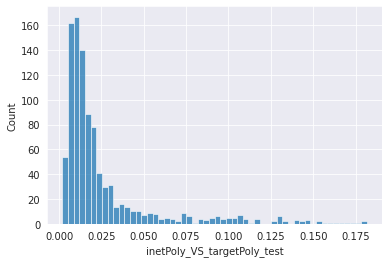

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

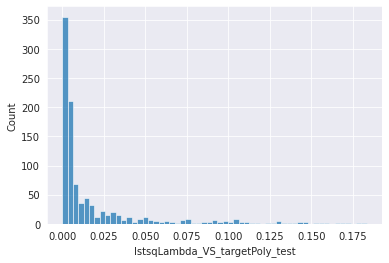

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

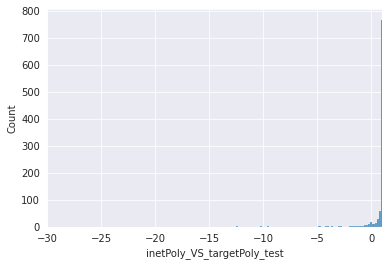

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

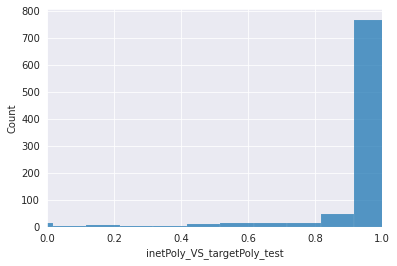

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

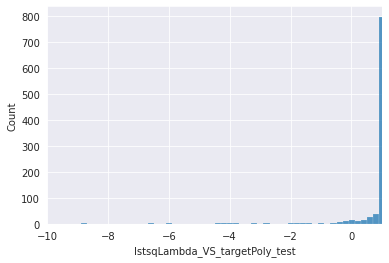

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

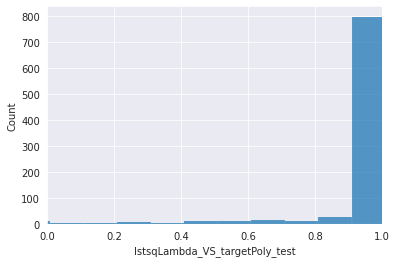

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.0055*a**1.0 - 0.5873*a**2.0 - 0.937*a**3.0 - 0.067*a**4.0 + 0.4853*a**5.0 + 0.5663

LSTSQ Target Poly:


0.1604*a**1.0 - 1.5299*a**2.0 + 1.2296*a**3.0 - 2.2679*a**4.0 + 1.3069*a**5.0 + 0.5592

LSTSQ Lambda Poly:


0.1604*a**1.0 - 1.5299*a**2.0 + 1.2296*a**3.0 - 2.2679*a**4.0 + 1.3069*a**5.0 + 0.5592

I-Net Poly:


-0.399699985980988*a**1.0 - 0.28889998793602*a**2.0 - 0.389800012111664*a**3.0 - 0.137899994850159*a**4.0 - 0.000600000028498471*a**5.0 + 0.620100021362305

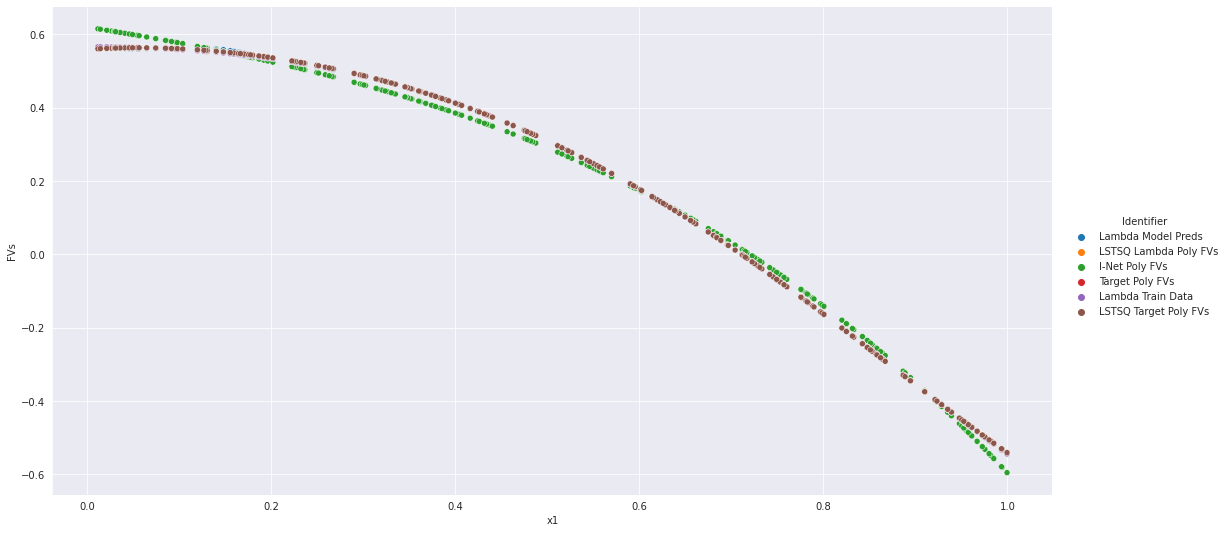

+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0010622694651814197 | 0.9999815290718724 |   -    |  0.1604*a**1.0 - 1.5299*a**2.0 + 1.2296*a**3.0 -   |
|            vs.            |                       |                    |        |       2.2679*a**4.0 + 1.3069*a**5.0 + 0.5592       |
|  LSTSQ Lambda Preds Poly  |                       |                    |        |                                                    |
|                           |                       |                    |        |                                                    |
|       Lambda Preds        |  0.01933895

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

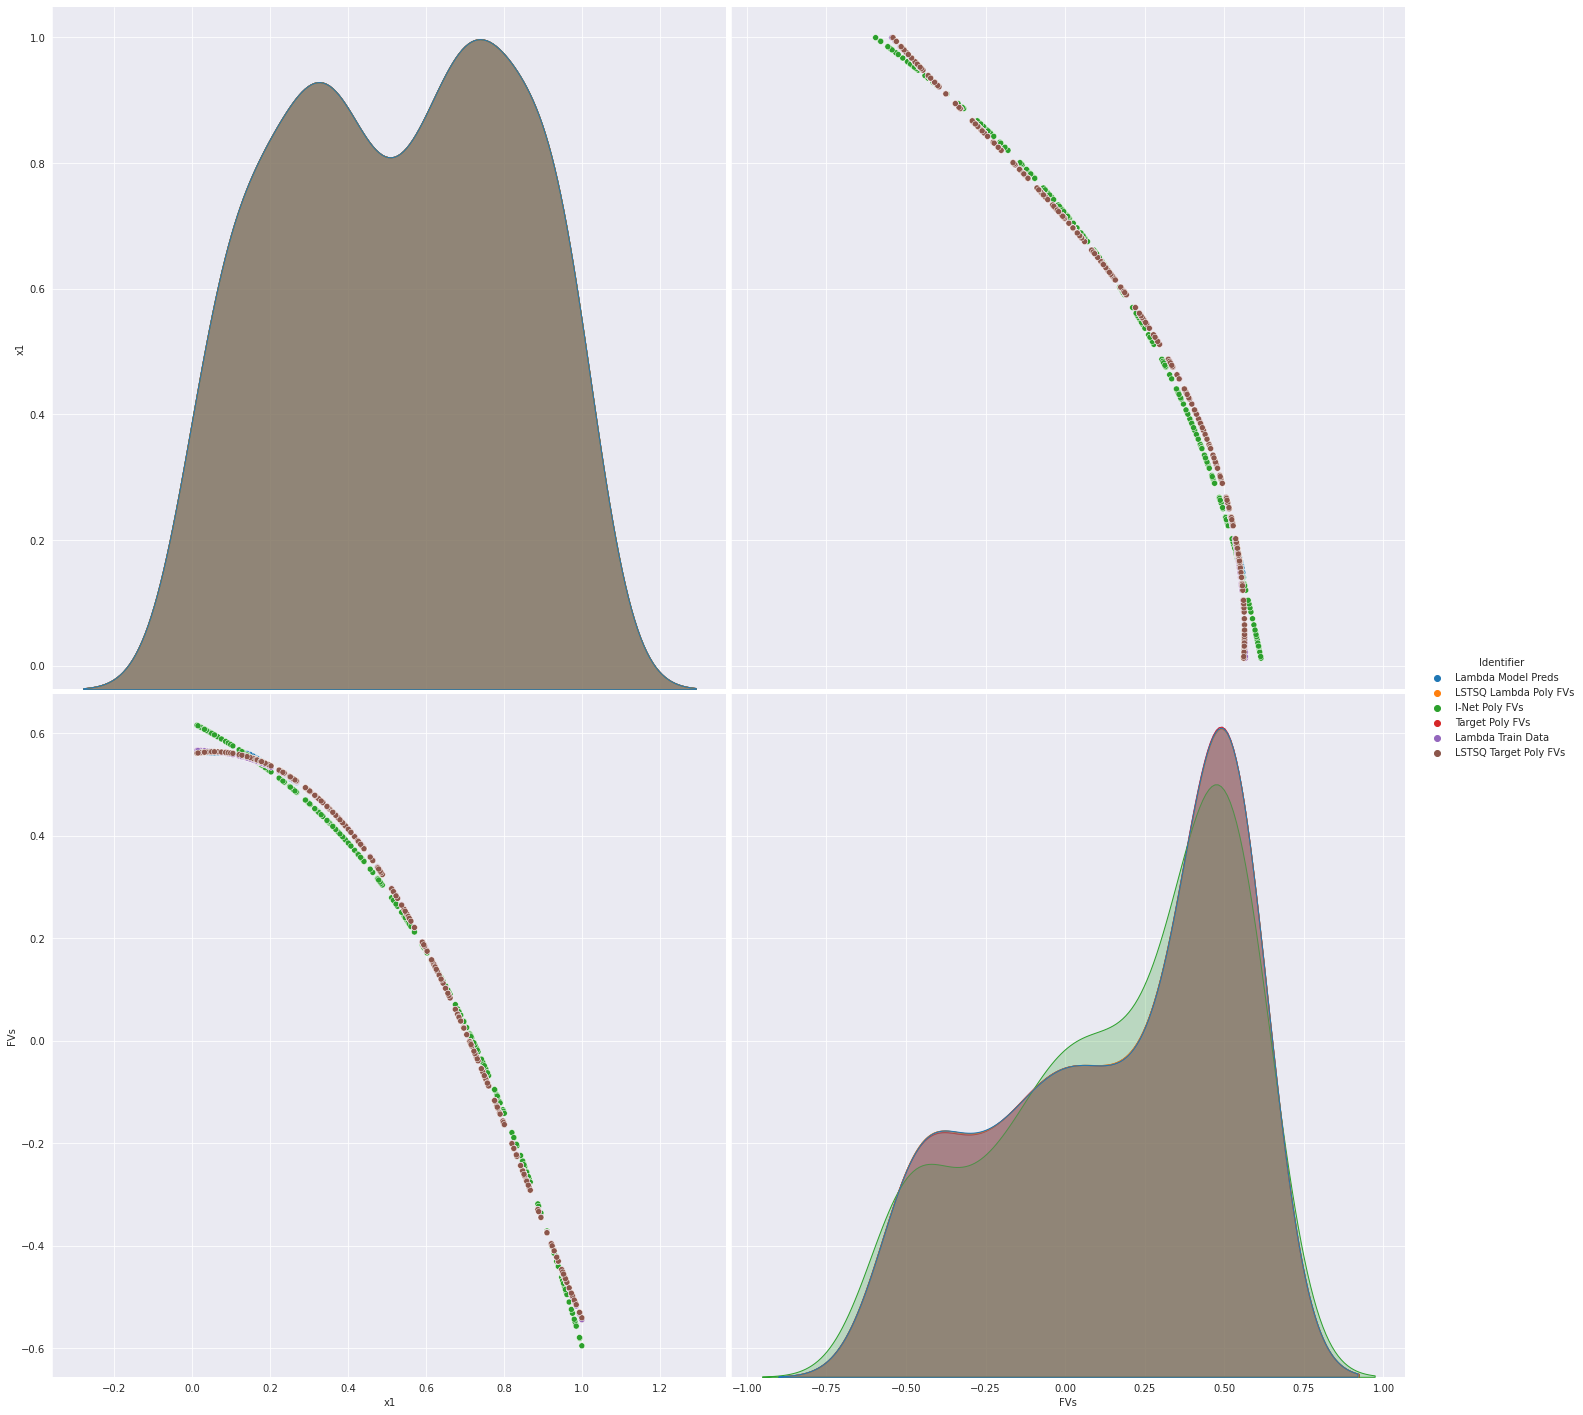

+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0010622694651814197 | 0.9999815290718724 |   -    |  0.1604*a**1.0 - 1.5299*a**2.0 + 1.2296*a**3.0 -   |
|            vs.            |                       |                    |        |       2.2679*a**4.0 + 1.3069*a**5.0 + 0.5592       |
|  LSTSQ Lambda Preds Poly  |                       |                    |        |                                                    |
|                           |                       |                    |        |                                                    |
|       Lambda Preds        |  0.01933895

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

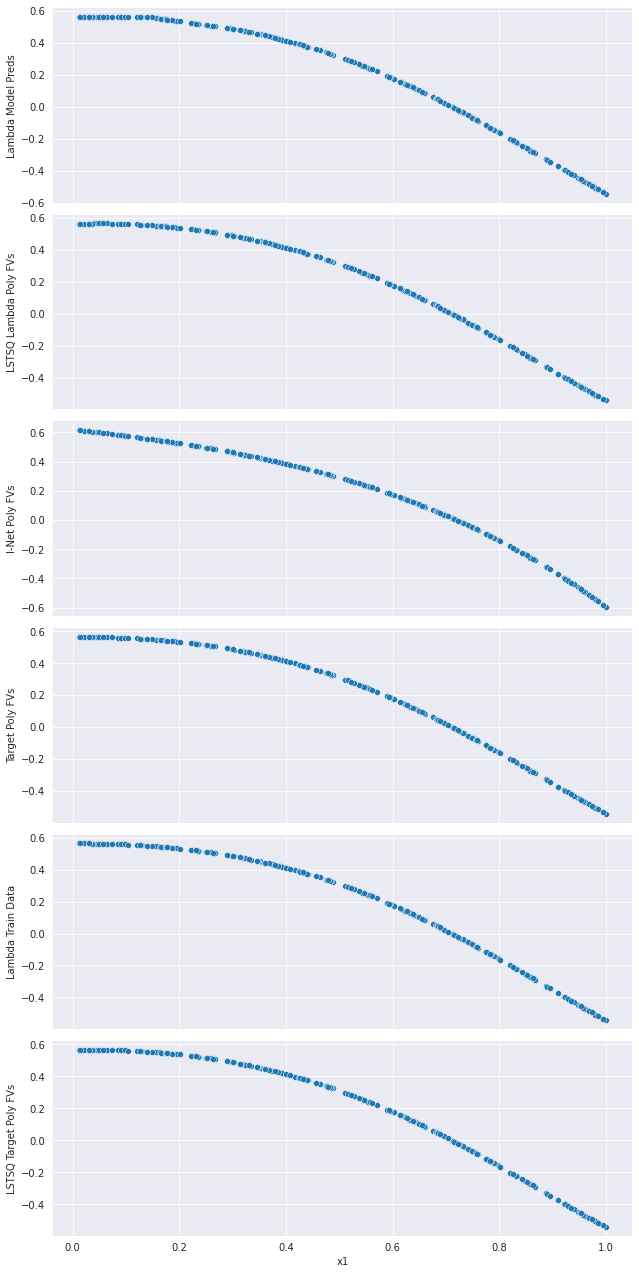

+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0010622694651814197 | 0.9999815290718724 |   -    |  0.1604*a**1.0 - 1.5299*a**2.0 + 1.2296*a**3.0 -   |
|            vs.            |                       |                    |        |       2.2679*a**4.0 + 1.3069*a**5.0 + 0.5592       |
|  LSTSQ Lambda Preds Poly  |                       |                    |        |                                                    |
|                           |                       |                    |        |                                                    |
|       Lambda Preds        |  0.01933895

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0316


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3945


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6153


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()